# Analitic model for single qubit

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import qutip as qu
import random
import pickle
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from settings import DATA_DIR, ANNEALING_SCHEDULE_XLS

df = pd.read_excel(ANNEALING_SCHEDULE_XLS, sheet_name=1)
nominal_temp_ghz = 13.5 / 47.9924341590788

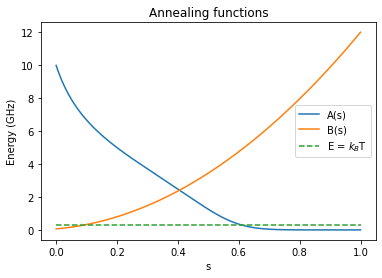

In [2]:
plt.figure()
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), nominal_temp_ghz * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

## Last time results

In [3]:
biases_ex, spin_up_ex, dspin_up_ex = pickle.load(open(DATA_DIR / "results.pickle", "rb"))

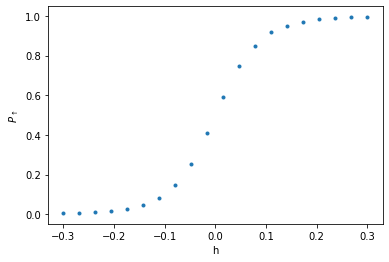

In [4]:
# ground state population vs h graph
plt.figure()
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.show()

## Solving Schroedinger eq: analitic solution at T=0

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Considering a linear ramping of s with time (from $t_i=0$ to $t_f = 20 \mu s$)

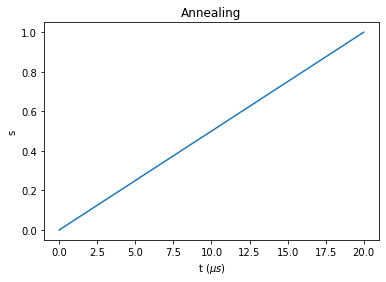

In [5]:
# linear foward anneal schedule
plt.figure()
plt.plot([0, 20], [0, 1])
plt.title('Annealing')
plt.xlabel('t ($\mu s$)')
plt.ylabel('s')
plt.show()

$$ i \hbar \frac{\partial}{\partial t} | \psi(t) \rangle = H(t) | \psi (t) \rangle $$

### Numerical integration

We can numerically solve schroedinger equation:
$$ \hat{\rho}(t+dt) = \hat{\rho}(t) - \frac{i}\hbar dt \left[H(t), \hat{\rho} (t) \right] $$

We need to choose a time interval $dt$ small such that $dt \times H(t) / \hbar << 1$.

Remebering that $H(t) / \hbar \sim 5 GHz$, we need $dt < 2 \times 10^{-10} s$

In [6]:
# evolution with schroedinger equation
def schroedinger_evolution(t, h):
    '''
    Given the time evolution 't' (np.array) and the bias 'h' (float)
    This function evolves the hamiltonian ground state according to Schroedinger equation.
    Return the final density matrix after evolution.
    '''
    # coefficients for linear annealing with time
    t = 1000 * t  # time (ns)
    
    A = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['A(s) (GHz)'])
    B = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['B(s) (GHz)'])

    H0 = - np.array([[0, 1], [1, 0]]) / 2  # initial hamiltonian
    H1 = - h * np.diag([1, -1]) / 2  # final hamiltonian
    
    H = lambda x: A(x) * H0 + B(x) * H1
    
    # initial state of evolution
    rho = np.array([[1, 1], [1, 1]]) / 2
    sigmax = []
    sigmaz = []
    err = 0
    img = 0
    
    def hamiltonian_term(ham, p):
        return ham @ p - p @ ham
    
    # perform evolution
    dt = t[1] - t[0]
    for x in t:        
        # 4th order Runge-Kutta
        k1 = - 1j * dt * hamiltonian_term(H(x), rho)
        k2 = - 1j * dt * hamiltonian_term(H(x + dt / 2), rho + k1 / 2)
        k3 = - 1j * dt * hamiltonian_term(H(x + dt / 2), rho + k2 / 2)
        k4 = - 1j * dt * hamiltonian_term(H(x + dt), rho + k3)

        # update rho
        rho = rho + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
        
        # save expectation value of operators
        sigmax.append(rho[0][1] + rho[1][0])
        sigmaz.append(rho[0][0] - rho[1][1])
        
        # check normalization
        err += abs(1 - np.trace(rho)) ** 2
        img += np.imag(sigmax[-1]) ** 2 + np.imag(sigmaz[-1]) ** 2
    
    # converting expectation values to array
    sigmaz = np.array(sigmaz)
    sigmax = np.array(sigmax)
    
    # check consitency
    assert(err < 0.01)
    assert(not any(np.iscomplex(sigmax)))
    assert(not any(np.iscomplex(sigmaz)))  
    
    return np.real(sigmaz), np.real(sigmax)

In [7]:
t = np.linspace(0, 20, 10 ** 5 + 1)
print(f'dt: {(t[1] - t[0]) / 10 ** 6} s')
sigmaz, sigmax = schroedinger_evolution(t, 0.3)

dt: 2e-10 s


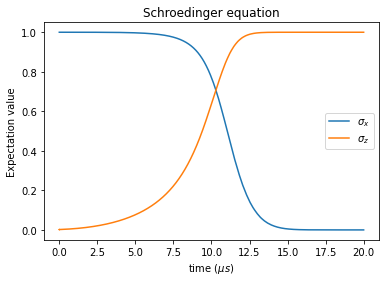

In [8]:
plt.figure()
plt.plot(t, sigmax, label='$\sigma_x$')
plt.plot(t, sigmaz, label='$\sigma_z$')

plt.title('Schroedinger equation')
plt.xlabel('time ($\mu s$)')
plt.ylabel(r'Expectation value')
plt.legend()
plt.show()

The following block takes a bit to execute:

In [ ]:
# perform schroedinger evolution for t_final = 20 mu s
t = np.linspace(0, 20, 10 ** 5 + 1)

biases_teo = np.logspace(-4, -0.5, 8)
biases_teo = sorted(np.concatenate((- biases_teo, biases_teo)))

# performing numerical calculation
p_up = []
for h in tqdm(biases_teo):
    sigmaz, sigmax = schroedinger_evolution(t, h)
    p_up.append(sigmaz[-1] / 2 + 0.5)

# save results on file
pickle.dump((biases_teo, p_up), open(DATA_DIR / f"schroedinger{str(t[-1])}.pickle", "wb"))

In [9]:
# perform schroedinger evolution for t_final = 0.03 mu s
t = np.linspace(0, 0.03, 10 ** 2 + 1) # mu s

biases_teo = np.linspace(-0.3, 0.3, 100)  # GHz

# performing numerical calculation
p_up = []
for h in tqdm(biases_teo):
    sigmaz, sigmax = schroedinger_evolution(t, h)
    p_up.append(sigmaz[-1] / 2 + 0.5)

# save results on file
pickle.dump((biases_teo, p_up), open(DATA_DIR / f"schroedinger{str(t[-1])}.pickle", "wb"))

100%|██████████| 100/100 [00:01<00:00, 90.01it/s]


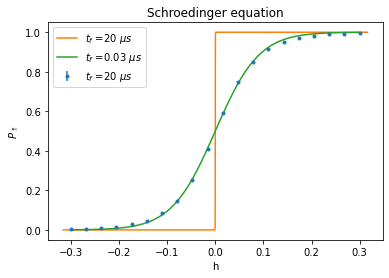

In [10]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open(DATA_DIR / "schroedinger20.0.pickle", "rb"))
biases_teo1, spin_up_teo1 = pickle.load(open(DATA_DIR / "schroedinger0.03.pickle", "rb"))

# ground state population vs h, experiment and theory
plt.figure()
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='$t_f$ =20 $\mu s$')
plt.plot(biases_teo0, spin_up_teo0, label='$t_f$ =20 $\mu s$')
plt.plot(biases_teo1, spin_up_teo1, label='$t_f$ =0.03 $\mu s$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

### QuTiP Toolkit

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

In [11]:
# evolution with schroedinger equation
def schroedinger_evolution_qu(t_f, h):
    
    # coefficients for linear annealing with time
    t = t_f * 1000 * df['s'].to_numpy()  # time (ns)

    S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
    S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])
    
    # initial state of evolution
    psi0 = (qu.basis(2, 0) + qu.basis(2, 1)).unit()

    H0 = - qu.sigmax() / 2  # initial hamiltonian
    H1 = - h * qu.sigmaz() / 2  # final hamiltonian
    H = [[H0, S0], [H1, S1]]
    
    # actual evolution
    result = qu.sesolve(H, psi0, t, [qu.sigmaz()])
    
    return result

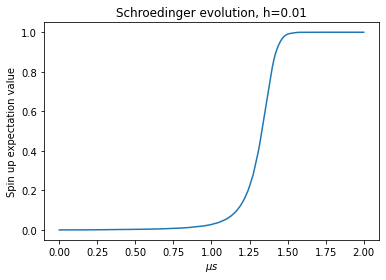

In [12]:
# plotting spin up expectation value during evolution
h = 0.01
result = schroedinger_evolution_qu(2, h)

plt.figure()
plt.plot(result.times / 1000, result.expect[0])

plt.title(f'Schroedinger evolution, h={h}')
plt.xlabel('$\mu s$')
plt.ylabel('Spin up expectation value')
plt.show()

The following block takes a bit to execute:

In [ ]:
# perform schroedinger evolution for t_final = 20 mu s
t_final = 20  # mu s

biases_q = np.logspace(-4, -0.5, 8)
biases_q = sorted(np.concatenate((- biases_q, biases_q)))

# performing numerical calculation
p_up = [(schroedinger_evolution_qu(t_final, h).expect[0][-1] + 1) / 2 for h in biases_q]

# save results on file
pickle.dump((biases_q, p_up), open(DATA_DIR / f"qu_schroedinger{str(t_final)}.pickle", "wb"))

In [13]:
# perform schroedinger evolution for t_final = 0.03 mu s
t_final = 0.03  # mu s

biases_q = np.linspace(-0.3, 0.3, 100)  # GHz

# performing numerical calculation
p_up = [(schroedinger_evolution_qu(t_final, h).expect[0][-1] + 1) / 2 for h in biases_q]

# save results on file
pickle.dump((biases_q, p_up), open(DATA_DIR / f"qu_schroedinger{str(t_final)}.pickle", "wb"))

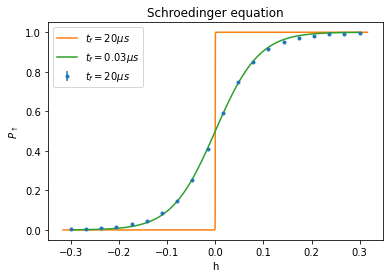

In [14]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open(DATA_DIR / "qu_schroedinger20.pickle", "rb"))
biases_teo1, spin_up_teo1 = pickle.load(open(DATA_DIR / "qu_schroedinger0.03.pickle", "rb"))

# ground state population vs h, experiment and theory
plt.figure()
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='$t_f = 20 \mu s$')
plt.plot(biases_teo0, spin_up_teo0, label='$t_f = 20 \mu s$')
plt.plot(biases_teo1, spin_up_teo1, label='$t_f = 0.03 \mu s$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

## Lindbladian: considering thermal noise

$$ \dot{\rho} = -i \left[ \mathcal{H}, \rho \right] + \sum_k \left( L_k \rho L_k ^ \dagger - \frac{1}{2} L_k^\dagger L_k \rho - \frac{1}{2} \rho L_k^\dagger L_k \right) $$

With $ \{ L_k \}_{k=1}^{d^2-1} $ Linblad operators, traceless ortoghonal basis.

### Microscopic model

Reference: *Tameem Albash et al 2012 New J. Phys. 14 123016*  [https://iopscience.iop.org/article/10.1088/1367-2630/14/12/123016](https://iopscience.iop.org/article/10.1088/1367-2630/14/12/123016)

We can think at the qubit S, with hamiltonian $H_S$, coupled with the environment E with hamiltonian $H_E$, initialized in the Gibbs state $\rho_E=\exp(-\beta H_E) / \mathcal{Z}_E $, through the interaction hamiltonian $H_I$.

$$ H_{S} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z, \qquad H_E = \sum_{k=1}^\infty \omega_k b_k^\dagger b_k, \qquad
H_I = \sigma^z \otimes \left[ \sum_k g_k^i \left( b_k^\dagger + b_k \right) \right] $$

Where $b_k^\dagger$ and $b_k$ are the rising and lowering operator of the oscillator with frequency $\omega_k$, and $g_k$ is the coupling constant of such mode to the system S.

The Lindblad master equation takes the form:
$$ \dot{\rho}(t) = -i[H_s(t), \rho(t)] + \gamma(\omega_{ge}(t)) \left( L_{eg}(t) \rho(t) L_{eg} ^ \dagger(t) - \frac{1}{2} L_{eg}^\dagger (t) L_{eg} (t) \rho (t) - \frac{1}{2} \rho (t) L_{eg}^\dagger (t) L_{eg} (t) \right)  + \gamma(\omega_{eg}(t)) \left( L_{ge}(t) \rho(t) L_{ge} ^ \dagger(t) - \frac{1}{2} L_{ge}^\dagger (t) L_{ge} (t) \rho (t) - \frac{1}{2} \rho (t) L_{ge}^\dagger (t) L_{ge} (t) \right) $$
plus terms $\rightarrow 0$ in the adiabatic limit.

In this model, the Lindblad operator $L_{eg}$ and $L_{ge}$ are respectively the raising and lowering operators ($L_{ab}=L_{a \leftarrow b}$):
$$\newcommand{\ket}[1]{|#1\rangle}
\newcommand{\bra}[1]{\langle#1|}$$
$$ L_{ab} = \ket{\epsilon_a(t)}\bra{\epsilon_a(t)} \sigma^z \ket{\epsilon_b(t)}\bra{\epsilon_b(t)} $$

The frequency $\omega$ is defined as the difference between eigenvalues:
$$\omega_{ba} = \epsilon_b - \epsilon_a $$

Assuming the environment state initialised to a gibbs state of inverse temperature $\beta = 1 / k_BT$, the transition rates are:

$$ \gamma(\omega) = \frac{2 \pi J(|\omega|)}{1-\exp(-\beta|\omega|)}g_{|\omega|}^2 \left( \Theta(\omega) + e^{-\beta |\omega|} \Theta(-\omega) \right) $$

Where $J(\omega)$ is an Ohmic bath spectral function with cutoff frequency $\omega_c$
$$ J(\omega)=\eta \omega \exp(-\omega / \omega_c), \qquad [\eta]=s^2 $$

### Numerical integration

In [15]:
# function to evolve rho
omega_c = 8 * np.pi
beta = 1 / nominal_temp_ghz
g2 = 0.4 / (2 * np.pi)


def hamiltonian_term(ham, p):
    return ham @ p - p @ ham


def dissipator_term(L, p):
    L_dag = L.conj().T
    L2 = L_dag @ L
    return L @ p @ L_dag - p @ L2 / 2 - L2 @ p / 2


def liovillian(ham, p):
    # hamiltonian eigenvals and eigenvects
    eigenvalues, eigenvectors = np.linalg.eigh(ham)
    omega = eigenvalues[1] - eigenvalues[0]
    assert omega >= 0

    # Lindblad rates
    gammap = 2 * np.pi * omega * np.exp(- omega / omega_c) / (1 - np.exp(-beta*omega)) * g2
    gammam = gammap * np.exp(-beta * omega)
    
    # Lindblad operators
    a = eigenvectors[:, 0]
    b = eigenvectors[:, 1]
    a_sigmaz_b = a.conj() @ np.diag([1, -1]) @ b
    Lab = a_sigmaz_b * np.outer(a, b)
    Lba = a_sigmaz_b * np.outer(b, a)
    
    # computing p_new
    p_new = -1j * hamiltonian_term(ham, p)
    p_new += gammap * dissipator_term(Lab, p)
    p_new += gammam * dissipator_term(Lba, p)
    
    # print(gammap, gammam, a_sigmaz_b)
    # print(omega)
    
    return p_new

In [16]:
# evolution with lindblad_evolution master equation
def lindblad_evolution(t, h):
    '''
    Given the time evolution 't' (np.array) and the bias 'h' (float)
    This function evolves the hamiltonian ground state according to Lindblad master equation.
    Return the final density matrix after evolution.
    '''
    # coefficients for linear annealing with time
    t = 1000 * t  # time (ns)
    
    A = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['A(s) (GHz)'])
    B = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['B(s) (GHz)'])
    
    # hamiltonian
    H0 = - np.array([[0, 1], [1, 0]]) / 2  # initial hamiltonian
    H1 = - h * np.diag([1, -1]) / 2  # final hamiltonian
    
    H = lambda x: A(x) * H0 + B(x) * H1
    
    # initial state of evolution
    rho = np.array([[1, 1], [1, 1]]) / 2
    
    # results
    sigmax = []
    sigmaz = []
    err = 0
    img = 0
    
    # perform evolution
    dt = t[1] - t[0]
    
    for x in t:
        # 4th order Runge-Kutta
        k1 = dt * liovillian(H(x), rho)
        k2 = dt * liovillian(H(x + dt / 2), rho + k1 / 2)
        k3 = dt * liovillian(H(x + dt / 2), rho + k2 / 2)
        k4 = dt * liovillian(H(x + dt), rho + k3)

        # update rho
        rho = rho + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
        
        # save expectation value of operators
        sigmax.append(rho[0][1] + rho[1][0])
        sigmaz.append(rho[0][0] - rho[1][1])
        
        # check runge kutta errors (normalization and hermitianity)
        err += abs(1 - np.trace(rho)) ** 2
        img += np.imag(sigmax[-1]) ** 2 + np.imag(sigmaz[-1]) ** 2
        
    # converting expectation values to array
    sigmaz = np.array(sigmaz)
    sigmax = np.array(sigmax)
    
    # check consitency
    assert(err < 1e-10)
    assert(img < 1e-10) 
    
    # print('Errori:', err, img)
    
    return np.real(sigmaz), np.real(sigmax)

In [17]:
t = np.linspace(0, 20, 10 ** 5 + 1)
h = 0.05

print(f'dt: {(t[1] - t[0]) / 10 ** 6} s')
zs, xs = schroedinger_evolution(t, h)
sigmaz, sigmax = lindblad_evolution(t, h)

dt: 2e-10 s


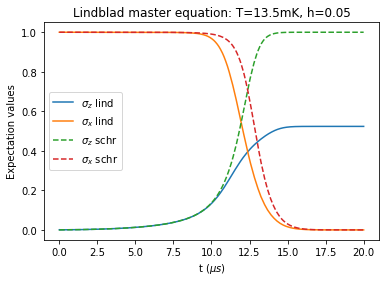

In [18]:
plt.figure()
plt.plot(t, sigmaz, label='$\sigma_z$ lind')
plt.plot(t, sigmax, label='$\sigma_x$ lind')

plt.plot(t, zs, ls='--', label='$\sigma_z$ schr')
plt.plot(t, xs, ls='--', label='$\sigma_x$ schr')

plt.title('Lindblad master equation: T=13.5mK, h=0.05')
plt.xlabel('t ($\mu s$)')
plt.ylabel('Expectation values')
plt.legend()
plt.show()

### Various h Lindblad evolution

The following block takes a long time to execute, moved implemetation in script *.py* for faster results:

In [ ]:
# perform schroedinger evolution for t_final = 20 mu s
temperatures = np.linspace(12, 13, 11)  # mK

for temp in tqdm(temperatures):
    t = np.linspace(0, 20, 10 ** 5 + 1)

    beta = 47.9924341590788 / temp  # 1 / GHz
    
    biases_q = np.linspace(-0.3, 0.3, 50)
    p_up = []

    # performing numerical calculation
    for h in tqdm(biases_q):
        sigmaz, sigmax = lindblad_evolution(t, h)
        p_up.append(sigmaz[-1] / 2 + 0.5)

    # save results on file
    pickle.dump((biases_q, p_up), open(DATA_DIR / f"qu_lindblad_various_h{temp}.pickle", "wb"))

T=13.45, fit err=58.80825985022532
T=13.60, fit err=35.897830618217256
T=13.65, fit err=31.047867133976258
T=13.70, fit err=27.578956748096164
T=13.75, fit err=25.48374772419486
T=13.80, fit err=24.754934642084308
T=13.85, fit err=25.385258016968887
T=13.90, fit err=27.36750392118012
T=14.00, fit err=35.359133141638544


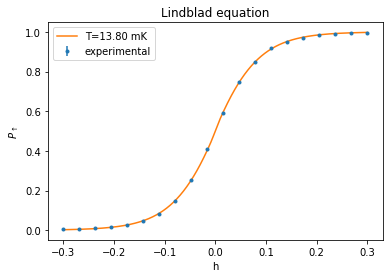

In [20]:
# opening saved data
import glob

# ground state population vs h, experiment and theory
plt.figure()
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='experimental')

for f in sorted(DATA_DIR.glob("qu_lindblad_various_h*.pickle")):
    h, p = pickle.load(open(f, "rb"))
    temp = float(f.name[21:-7])
    
    # smooth curve
    funct = scipy.interpolate.CubicSpline(h, p)
    xx = np.linspace(-0.3, 0.3, 1000)
    if temp == 13.80:
        plt.plot(xx, funct(xx), label=f'T={temp:.2f} mK')
    
    # return error on fit
    err = 0
    for x, y, dy in zip(biases_ex, spin_up_ex, dspin_up_ex):
        err += (y - funct(x)) ** 2 / dy ** 2
    
    print(f'T={temp:.2f}, fit err={err}')

plt.title('Lindblad equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

'Fit' parameters:
- $\omega_c = 8 \times \pi GHz$
- $\eta g^2 = 0.4 / (2 \times \pi)$
- $\beta = 13.80 \pm 0.05 mK$

# Qubit pair temperature measurements
Considering qubit pairs (A and B), we can choose the biases $h_1, h_2$ the coupling *J* and annealing parameter *s(t)*.

$$ \mathcal{H}_{\text{2 qubits}} = - \frac{A(s)}{2} \left[ \hat{\sigma}_x^A \otimes \mathbb{I}^B + \mathbb{I}^A \otimes \hat{\sigma}_x^B \right] + \frac{B(s)}{2} \left[ h_A \hat{\sigma}_z^A \otimes \mathbb{I}^B + h_B \mathbb{I}^A \otimes \hat{\sigma}_z^B + J \hat{\sigma}_z^A \otimes \hat{\sigma}_z^B \right] $$

In spirit of performing a similar calculation looking for temperature effect, we can choose a strong *J* and weak *h*s or viceversa.

We choose to se $J=1$ (strong), not to let temperature break entanglement.

## Instantaneous eigenstates

In [21]:
hA = 0.1
hB = 0
J = 1

# hamiltonian coefficients for linear annealing with time
s = np.linspace(0, 1, 1000)

# annealing parameters
S0 = qu.Cubic_Spline(s[0], s[-1], df['A(s) (GHz)'])
S1 = qu.Cubic_Spline(s[0], s[-1], df['B(s) (GHz)'])

# initial hamiltonian
H0 = -qu.tensor(qu.sigmax(), qu.identity(2)) / 2   
H0 -= qu.tensor(qu.identity(2), qu.sigmax()) / 2

# final hamiltonian
H1 = J * qu.tensor(qu.sigmaz(), qu.sigmaz()) / 2
H1 += hA * qu.tensor(qu.sigmaz(), qu.identity(2)) / 2
H1 += hB * qu.tensor(qu.identity(2), qu.sigmaz()) / 2

def H(x):
    return S0(x) * H0 + S1(x) * H1

Minimum gap between ground and 1st excited state: 0.419 GHz
Nominal thermal energy: 0.281 GHz


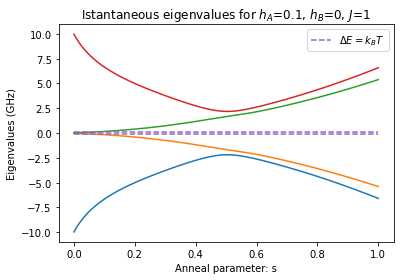

In [22]:
# plot hamiltonian istantanous eigenvalues vs annealing parameters
eigs = np.array([H(x).eigenenergies() for x in s])

plt.figure()
plt.title(f'Istantaneous eigenvalues for $h_A$={hA}, $h_B$={hB}, $J$={J}')

plt.plot(s, eigs[:,0])
plt.plot(s, eigs[:,1])
plt.plot(s, eigs[:,2])
plt.plot(s, eigs[:,3])

print(f'Minimum gap between ground and 1st excited state: {np.min(eigs[:,1] - eigs[:,0]):.3f} GHz')

print(f'Nominal thermal energy: {nominal_temp_ghz:.3f} GHz')
plt.plot(np.linspace(0, 1), nominal_temp_ghz * np.ones(50) / 2, c='C4', linestyle='--', label='$\Delta E=k_B T$')
plt.plot(np.linspace(0, 1), - nominal_temp_ghz * np.ones(50) / 2, c='C4', linestyle='--')

plt.xlabel('Anneal parameter: s')
plt.ylabel('Eigenvalues (GHz)')
plt.legend()
plt.show()

## Simulation

In [23]:
# scelgo il device
from dwave.system import DWaveSampler
import dwave.inspector

sampler = DWaveSampler(solver='DW_2000Q_6')

In [24]:
# setting run parameters
N = 20
biases = np.linspace(-0.3, 0.3, N)
J = -1
        
connections = [(n, n+4) for n in sampler.nodelist if (n % 8 < 4) and (n, n+4) in sampler.edgelist]
a_qubits = [n for n in sampler.nodelist if (n % 8 < 4) and (n, n+4) in sampler.edgelist]

In [25]:
# RUN different energy gap samples for all active spins in machine
quadratic_coupling = {active_coupler: J for active_coupler in connections}

for i, h in enumerate(biases):
    linear_offsets = {active_node: h * random.choice([-1, 1]) for active_node in a_qubits}
    
    # sampleset = sampler.sample_ising(linear_offsets, quadratic_coupling, num_reads = 10, auto_scale=False, label=f'2 qubit Boltzmann h={h}')
    
    # save data to file
    # pickle.dump((linear_offsets, quadratic_coupling, sampleset), open(DATA_DIR / f"2_qubits_boltzmann{i}.pickle", "wb"))

In [26]:
def state_population(linear_offsets, quadratic_coupling, sampleset):
    # compute the percentage of population of the states along z
    state = np.zeros(4)

    for a, b in quadratic_coupling:
        variables = np.array(sampleset.variables)

        for sample in sampleset.record.sample:
            index_a = np.where(variables == a)[0][0]
            index_b = np.where(variables == b)[0][0]
            x = sample[index_a]
            y = sample[index_b]

            if np.sign(linear_offsets[a]) < 0:
                x = -x
                y = -y

            if x == -1 and y == -1:
                state[0] += 1
            elif x == 1 and y == 1:
                state[1] += 1
            elif x == -1 and y == 1:
                state[2] += 1
            elif x == 1 and y == -1:
                state[3] += 1
            else:
                raise ValueError
    
    err = 1 / np.sqrt(4 * len(quadratic_coupling) * sampleset.record.num_occurrences.sum())
    
    return state / state.sum(), err

In [27]:
# load data from file
n2_spin_up = np.empty(N)
dn2_spin_up = np.empty(N)

for i in range(N):
    # load data from file    
    linear_offsets, quadratic_coupling, sampleset = pickle.load(open(DATA_DIR / f"2_qubits_boltzmann{i}.pickle", "rb"))
    
    # compute state population and error
    state, err = state_population(linear_offsets, quadratic_coupling, sampleset)
    if state[2] != 0 or state[3] != 0:
        print(f'h: {biases[i]}, state pop: {state}')
    
    # append result when both qubits are spin 'up'
    n2_spin_up[i] = state[0]
    if biases[i] < 0:
        n2_spin_up[i] = state[1]
    dn2_spin_up[i] = err

h: -0.23684210526315788, state pop: [9.63126844e-01 3.67748279e-02 9.83284169e-05 0.00000000e+00]
h: -0.17368421052631577, state pop: [9.25565388e-01 7.43362832e-02 0.00000000e+00 9.83284169e-05]
h: -0.0789473684210526, state pop: [7.66273353e-01 2.33529990e-01 9.83284169e-05 9.83284169e-05]
h: 0.047368421052631615, state pop: [6.79056047e-01 3.20747296e-01 9.83284169e-05 9.83284169e-05]
h: 0.1421052631578948, state pop: [8.90757129e-01 1.09144543e-01 9.83284169e-05 0.00000000e+00]
h: 0.20526315789473687, state pop: [9.44739430e-01 5.51622419e-02 0.00000000e+00 9.83284169e-05]


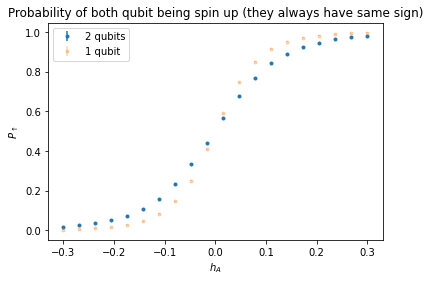

In [28]:
# ground state population vs h
plt.figure()
plt.errorbar(biases, n2_spin_up, dn2_spin_up, marker='.', linestyle='', label='2 qubits')
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='1 qubit', alpha=0.3)
plt.title(r'Probability of both qubit being spin up (they always have same sign)')
plt.xlabel('$h_A$')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

# Entanglement

$$ \mathcal{H}_{\text{2 qubits}} = - \frac{A(s)}{2} \left[ \hat{\sigma}_x^A \otimes \mathbb{I}^B + \mathbb{I}^A \otimes \hat{\sigma}_x^B \right] + \frac{B(s)}{2} \left[ h_A \hat{\sigma}_z^A \otimes \mathbb{I}^B + h_B \mathbb{I}^A \otimes \hat{\sigma}_z^B + J \hat{\sigma}_z^A \otimes \hat{\sigma}_z^B \right] $$

In [29]:
# Computing the entanglement of the state changing s
J = 1
h = [0.3, 0]

Schroendinger evolution: $h$ greater that thermal noise to avoid simulation with ME

In [30]:
# hamiltonian coefficients for linear annealing with time
t = np.linspace(0, 20, 10 ** 5) * 1000

# annealing parameters
S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])

# initial hamiltonian
H0 = -qu.tensor(qu.sigmax(), qu.identity(2)) / 2   
H0 -= qu.tensor(qu.identity(2), qu.sigmax()) / 2

# final hamiltonian
H1 = J * qu.tensor(qu.sigmaz(), qu.sigmaz()) / 2
H1 += h[0] * qu.tensor(qu.sigmaz(), qu.identity(2)) / 2
H1 += h[1] * qu.tensor(qu.identity(2), qu.sigmaz()) / 2

H = [[H0, S0], [H1, S1]]

psi_1qu = (qu.basis(2, 0) + qu.basis(2, 1)).unit()
psi0 = qu.tensor(psi_1qu, psi_1qu)

Max concurrence: 0.44421386088903875
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.00695993-0.27070213j]
 [0.00963332-0.38396137j]
 [0.02103035-0.81557813j]
 [0.00865193-0.33685006j]]


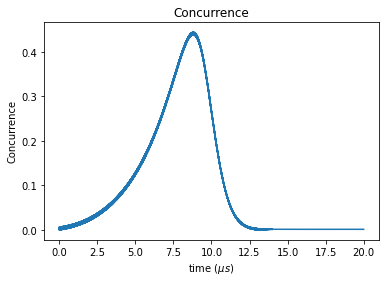

In [31]:
result = qu.sesolve(H, psi0, t, [])
entang = [qu.concurrence(result.states[i]) for i in range(len(result.times))]

max_entag_state = result.states[entang.index(max(entang))]

print('Max concurrence:', qu.concurrence(max_entag_state))
print(max_entag_state)

plt.figure()
plt.plot(result.times / 1000, entang)

plt.title(f'Concurrence')
plt.xlabel('time ($\mu s$)')
plt.ylabel('Concurrence')
plt.show()

## Change h mid anneal

https://docs.dwavesys.com/docs/latest/c_solver_1.html#h-gain-schedule

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( g(t) \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

In [32]:
from dwave.system import DWaveSampler

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]} \n')

print(f'Maximum h-schedule points: {sampler.properties["max_h_gain_schedule_points"]}')
print(f'h gain range: {sampler.properties["h_gain_schedule_range"]}')
print(f'Maximum slope allowed on this solver is {sampler.properties["h_gain_schedule_range"][1] / sampler.properties["annealing_time_range"][0]}')

# sampler.properties

Maximum anneal-schedule points: 12
Annealing time range: [1, 2000] μs
Maximum slope allowed on this solver is 1.0 

Maximum h-schedule points: 20
h gain range: [-5.0, 5.0]
Maximum slope allowed on this solver is 5.0


- Control 'linearly' through 20 points.
- Max range: [-5, 5]